In [69]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
import random

from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segementation
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.stats import kurtosis, skew


In [26]:
sorted_pieces = [
    [[0,2,8,9,10,12,13,14,19], [1,5,6,11,16,21,22,25,26], [3,4,7,15,17,18,20,24,27] ,[23]],
    [[2,7,4,8,10,11,12,12,14], [0,1,5,6,9,15,16,17,19]  , []                        ,[3,18,20]],
    [[2,5,6,17,19,20,22,23,24],[1,4,9,13,15,18,21,25,26], [3,7,8,10,11,12,14,16,27] ,[0]],
    [[0,1,2,5,11,12,13,16,17], [3,4,6,7,8,9,15,18,20]   , []                        ,[10,14,19]],
    [[1,3,5,7,8,9,11,15,18]  , [2,4,6,10,12,13,14,17,19], []                        ,[0,16]],
    [[3,4,6,7,9,10,15,19,24],  [0,8,12,14,16,17,18,20,26],[1,2,5,11,13,21,22,23,27] ,[25]],
    [[0,2,5,8,10,18,25,26,27], [1,3,4,12,14,15,17,21,23], [6,7,9,11,16,19,22,24,28] ,[13, 20]],
    [[0,1,7,9,12,14,19,23,27], [2,4,5,13,18,22,24,25,26], [3,8,10,11,15,16,17,20,21],[6]],
    [[0,1,2,5,6,8,11,12,14,15,16,18,20,21,23,26],[3,4,7,9,10,13,19,22,25],[]        ,[17,24]],
    [[0,2,4,5,6,13,17,23,25],  [1,9,10,12,14,15,16,19,22],[7,8,18,20,21,24,26,27,28],[3,11]],
    [[0,1,8,12,14,17,18,20,22],[2,3,4,9,10,15,16,21,23] , [5,6,7,11,13,19,25,26,27] ,[24]],
    [[1,2,5,6,9,11,14,15,18],  [3,4,7,8,10,12,13,16,17],  []                        ,[0]]
]

In [4]:
def load_textures(folder="train2_solutions", path="data_project"):
    paths = os.path.join(path, folder)
    files = os.listdir(paths)
    list_textures = []
    for file in files:
        if file.startswith("solution"):
            im = Image.open(f"{paths}/{file}").convert("RGB")
            list_textures.append(np.array(im))
    return list_textures

In [5]:
textures = load_textures()

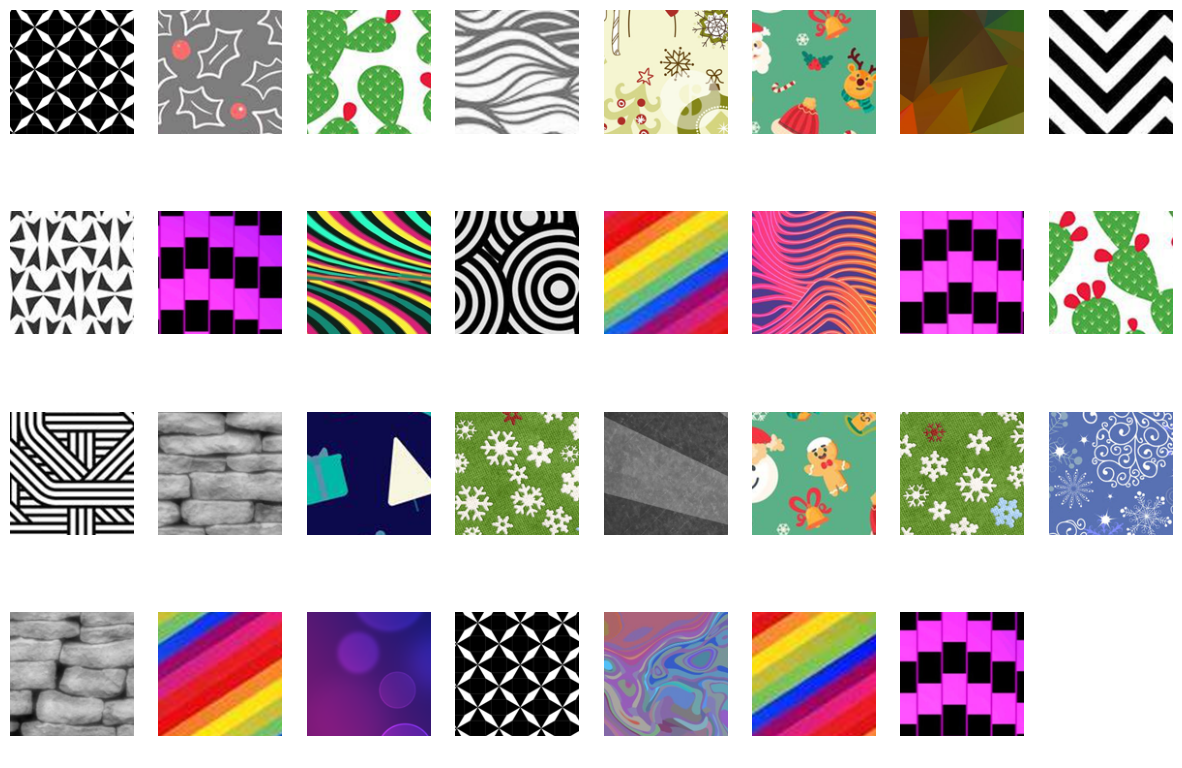

In [6]:
fig, axes = plt.subplots(4,8, figsize=(15,10))
for img,ax in zip(textures,axes.ravel()):
    index1 = random.randint(0, 2*128)
    index2 = random.randint(0, 2*128)
    ax.imshow(img[index1:128+index1,index2:128+index2])
    ax.axis("off")
axes[3,7].axis("off")
plt.show()

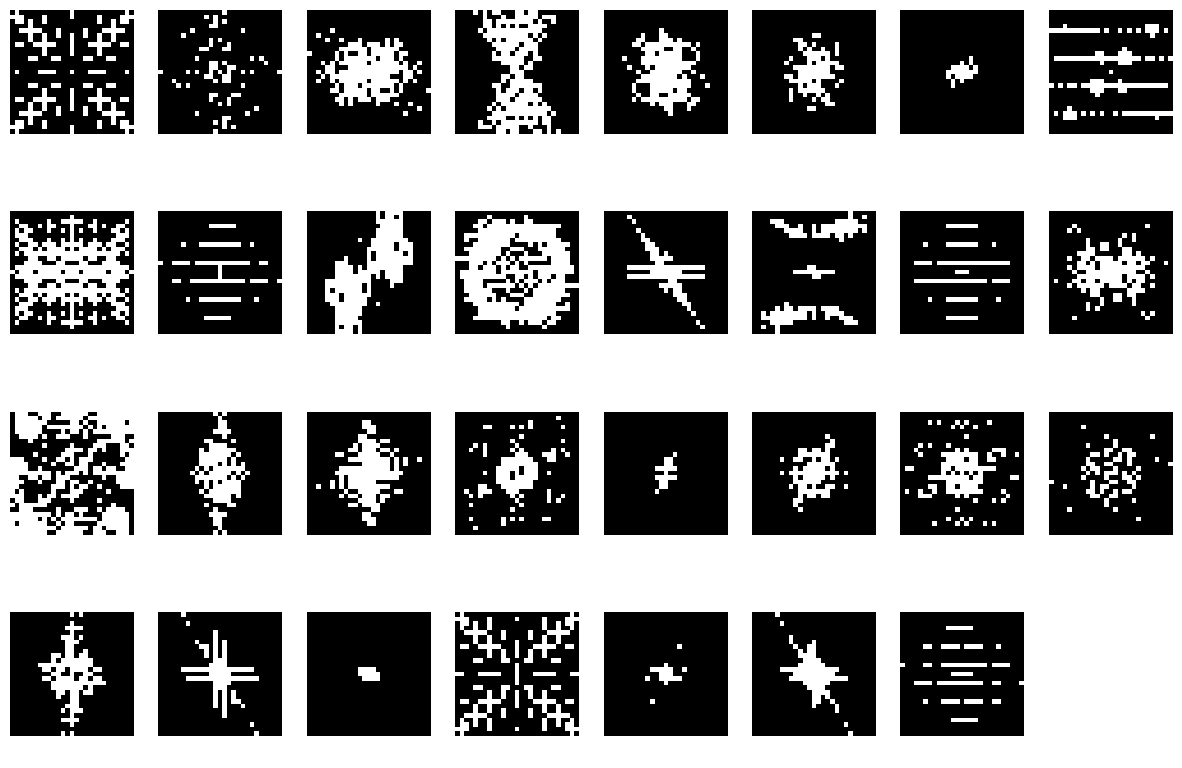

In [7]:
fig, axes = plt.subplots(4, 8, figsize=(15, 10))
for img, ax in zip(textures, axes.ravel()):
    index1 = random.randint(0, 2 * 128)
    index2 = random.randint(0, 2 * 128)
    transform = np.fft.fft2(rgb2gray(img[index1 : 128 + index1, index2 : 128 + index2]))
    fshift = np.fft.fftshift(transform)
    bout_d_image = np.log(np.abs(fshift[51:-50, 51:-50]))
    binary_bout = bout_d_image >4.5
    ax.imshow(binary_bout, cmap="gray")
    ax.axis("off")

axes[3, 7].axis("off")
plt.show()

In [117]:
def color_features(img):
    median = np.median(img, axis=(0, 1))
    std = np.std(img, axis=(0, 1))
    mean = np.mean(img, axis=(0, 1))
    kurtosis_c = kurtosis(img, axis=(0, 1))
    skew_c = skew(img, axis=(0, 1))
    img_hsv = rgb2hsv(img)
    median_hsv = np.median(img_hsv, axis=(0, 1))
    std_hsv = np.std(img_hsv, axis=(0, 1))
    mean_hsv = np.mean(img_hsv, axis=(0, 1))
    kurtosis_hsv = kurtosis(img_hsv, axis=(0, 1))
    skew_hsv = skew(img_hsv, axis=(0, 1))

    return np.hstack(
        [
            median,
            std,
            mean,
            kurtosis_c,
            skew_c,
            median_hsv,
            std_hsv,
            mean_hsv,
            kurtosis_hsv,
            skew_hsv,
        ]
    )

In [193]:
def fourier_features(img):
    transform = np.fft.fft2(rgb2gray(img))
    ft = np.log(np.abs(np.fft.fftshift(transform)))[1:, 1:]  # [51:-50, 51:-50]

    ft_median = np.median(ft)
    ft_mean = np.mean(ft)
    ft_std = np.std(ft)
    ft_kurtosis = kurtosis(ft, axis=(0, 1))
    ft_skew = skew(ft, axis=(0, 1))

    binary_ft = ft > 4.5
    non_zero = np.count_nonzero(binary_ft)
    v = np.stack(np.where(binary_ft), axis=1)
    cov = np.cov(v.T)
    eigval, eigvec = np.linalg.eig(cov)

    idx = np.argsort(eigval)
    eigval, eigvec = eigval[idx], eigvec[idx]

    angle = np.arctan2(eigvec[0][1], eigvec[0][0]) % (np.pi / 2)

    k, l = np.indices((127, 127)) - 63
    m_00 = np.sum(ft)
    m_20 = np.sum(k**2 * ft)
    m_02 = np.sum(l**2 * ft)
    M1 = m_02 + m_20

    return np.hstack(
        [
            ft_median,
            ft_mean,
            ft_std,
            ft_kurtosis,
            ft_skew,
            non_zero,
            eigval,
            angle,
            M1 / m_00,
        ]
    )

In [194]:
def get_features(img):
    # COLOR
    color = color_features(img)

    # FOURIER
    fourier = fourier_features(img)

    # EDGES
    canny_img = cv2.Canny(img, 50, 200)
    num_edges = np.count_nonzero(canny_img)

    return np.hstack([color, fourier, num_edges])

In [195]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

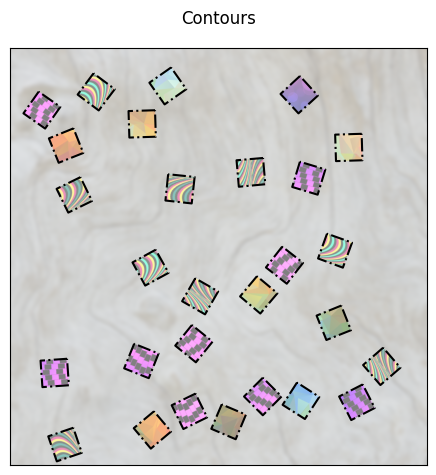

In [183]:
index_img = 5
img = imgs[index_img]
seg = Segementation(img)
seg.find_pieces()
seg.plot_contours()

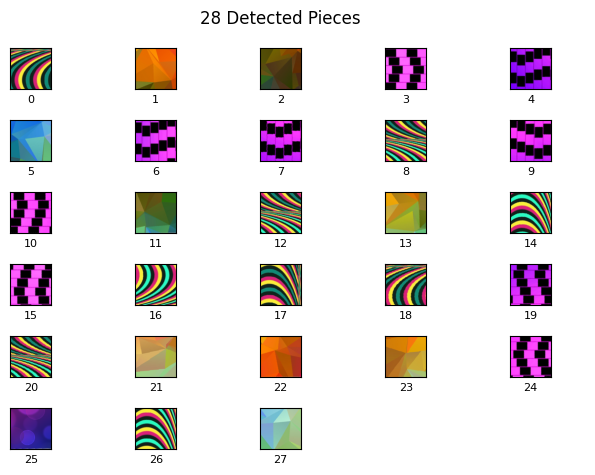

In [142]:
seg.plot_pieces()

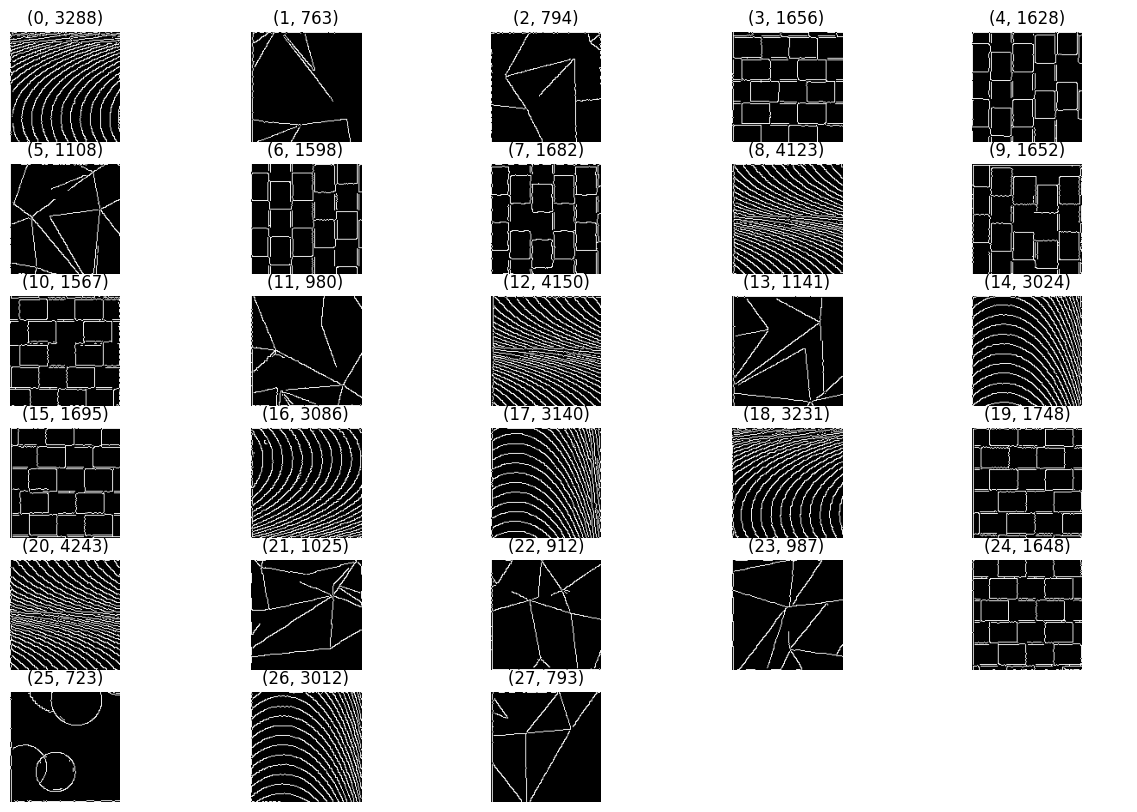

In [190]:
fig, axes = plt.subplots((len(seg.pieces)-1)// 5+1 , 5, figsize=(15, 10))

for i, (img, ax) in enumerate(zip(seg.pieces, axes.ravel())):
    canny_img = cv2.Canny(img,50,200)
    #ft = np.log(np.abs(np.fft.fft2(rgb2hsv(img),axes=(0,1))))
    
    ax.imshow(canny_img, cmap="gray")
    ax.axis("off")
    ax.set_title(f'{i, np.count_nonzero(canny_img)}')
    
for ax in axes.ravel()[len(seg.pieces):]:
    ax.axis("off")
plt.show()

In [83]:
def correlate(img1, img2):
    return (
        np.sum((img1 - np.mean(img1)) * (img2 - np.mean(img2))) / (np.std(img1) * np.std(img2) * np.size(img1))
    )

In [175]:
def get_correlation(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                max(correlate(b,img), correlate(np.rot90(b),img))
                for b in crop_imgs
            ]
        )
        distances.append(arr)

    distances = np.array(distances)

    return distances

In [176]:
def get_distances_non_binary(pieces):
    crop_imgs = []
    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        crop_img = np.log(np.abs(fshift[51:-50, 51:-50]))
        crop_imgs.append(crop_img)

    for img in crop_imgs:
        arr = np.array(
            [
                min(np.sum((b - img) ** 2), np.sum((np.rot90(b) - img) ** 2))
                for b in crop_imgs
            ]
        )
        distances.append(arr)


    distances = np.array(distances)
    normalized_distances = normalize(distances, axis=0)

    return normalized_distances

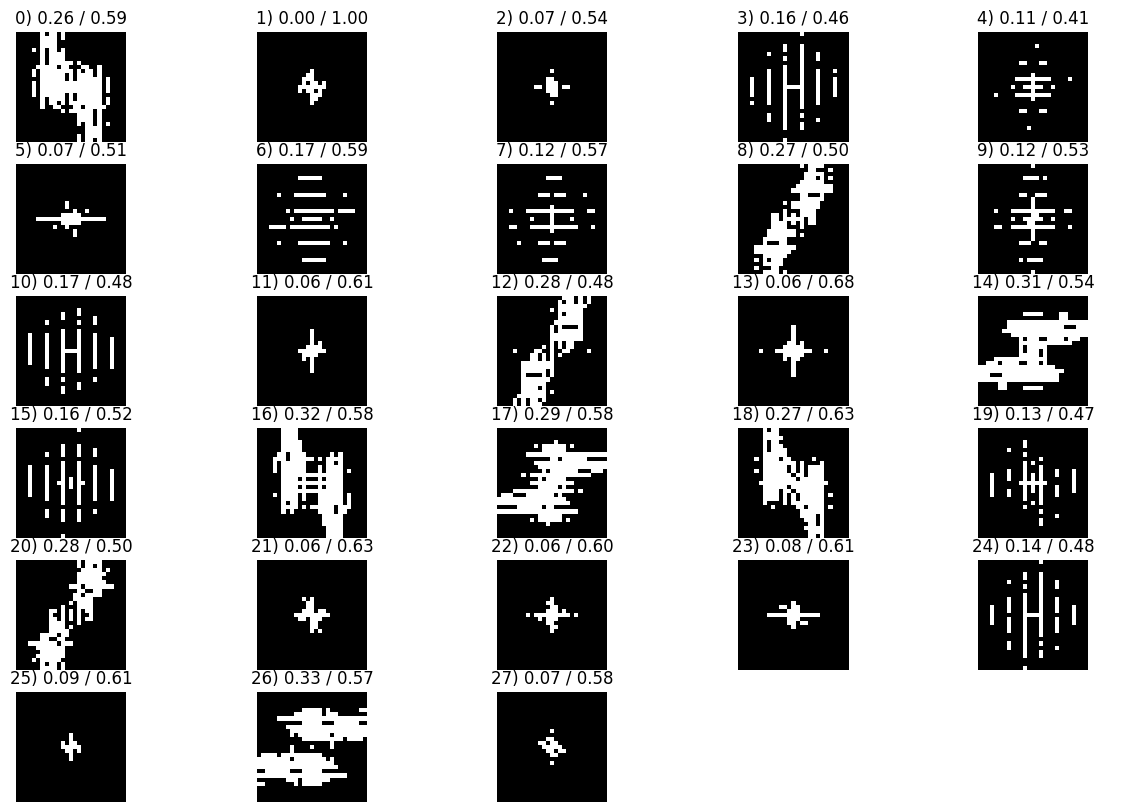

In [173]:
fig, axes = plt.subplots((len(seg.pieces)-1)// 5+1 , 5, figsize=(15, 10))

reference = 1
distances = get_distances_non_binary(seg.pieces)
correlations = get_correlation(seg.pieces)
bouts_d_image = []

for i, (img, ax, d) in enumerate(zip(seg.pieces, axes.ravel(), distances)):
    transform = np.fft.fft2(rgb2gray(img))
    fshift = np.fft.fftshift(transform)
    bout_d_image = np.log(np.abs(fshift[51:-50, 51:-50]))
    bouts_d_image.append(bout_d_image) 
    
    ax.imshow(bout_d_image>4.5, cmap="gray")
    ax.axis("off")
    ax.set_title(f'{i}) {distances[i][reference]:<.2f} / {correlations[i][reference]:<.2f}')
    
for ax in axes.ravel()[len(seg.pieces):]:
    ax.axis("off")
plt.show()

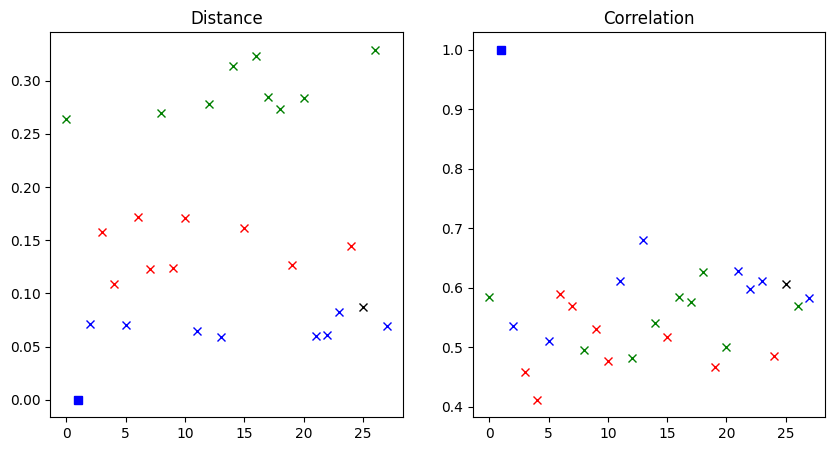

In [200]:
indexes = sorted_pieces[index_img]
colors = ["r", "g", "b", "k", "c", "m"]

dists_to_ref = np.array([distances[i][reference] for i in range(len(distances))])
corr_to_ref = np.array([correlations[i][reference] for i in range(len(distances))])

_,(ax1,ax2)= plt.subplots(1,2, figsize=(10,5))
for j, index in enumerate(indexes):
    if reference in index:
        ax1.plot(reference, dists_to_ref[reference], c=colors[j], marker='s')
        ax2.plot(reference, corr_to_ref[reference], c=colors[j], marker='s')
    ax1.plot(index, dists_to_ref[index].T, c=colors[j], marker="x", linestyle='none')
    ax2.plot(index, corr_to_ref[index].T, c=colors[j], marker="x", linestyle='none')
ax1.set_title("Distance")
ax2.set_title("Correlation")
plt.show()

In [197]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
distances = get_distances_non_binary(seg.pieces)
correlation = get_correlation(seg.pieces)
features = np.hstack([features, distances, correlation])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
features.shape

(28, 97)

In [198]:
pca = KernelPCA(n_components=3,kernel="rbf")
features_PCA = pca.fit_transform(features)

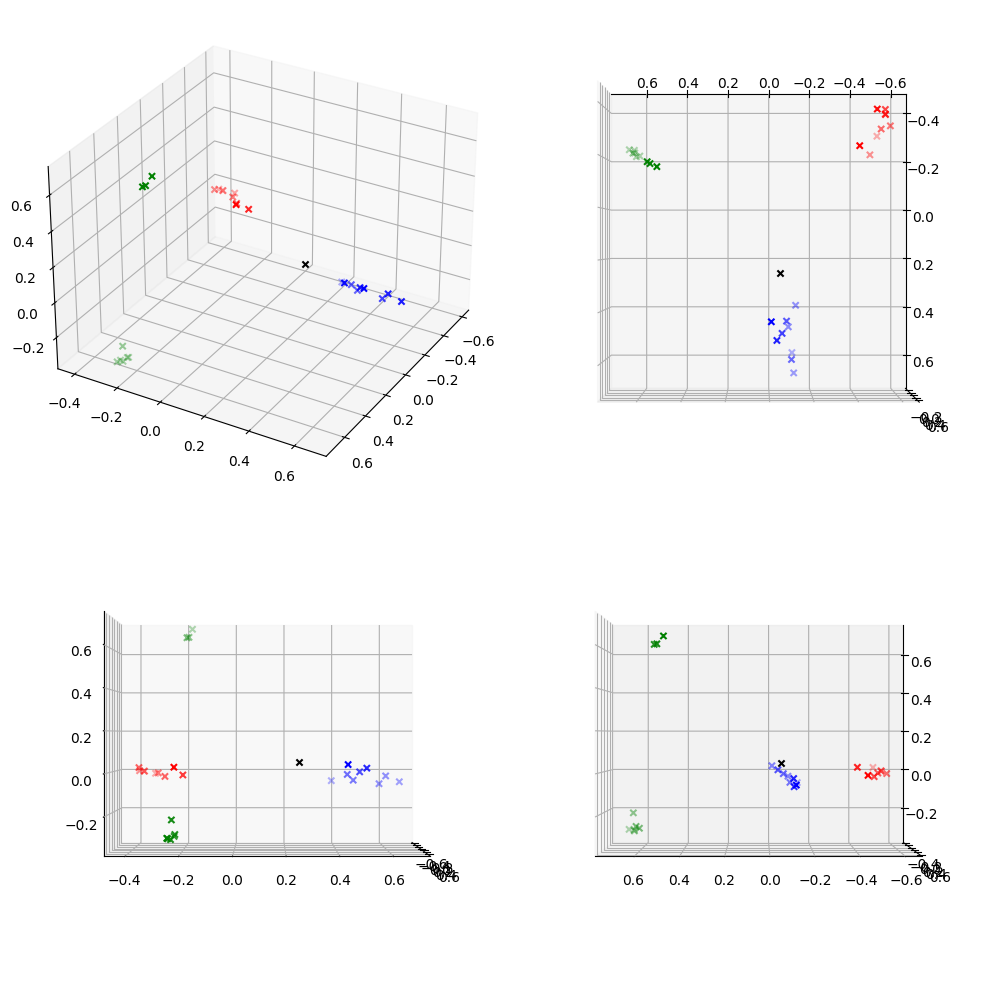

In [199]:
indexes = sorted_pieces[index_img]

colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]

fig = plt.figure(figsize=(10, 10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    for j, index in enumerate(indexes):
        ax.scatter(*features_PCA[index].T, c=colors[j], marker="x")
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
# plt.savefig(f'classification_{index_img}')
plt.show()

In [31]:
# features_cluster_with_outlier = features[indexes[2]+indexes[3]]
# pca = KernelPCA(n_components=3,kernel="rbf")
# features_PCA_o = pca.fit_transform(features_cluster_with_outlier)
# fig = plt.figure(figsize=(10, 10))
# for i, o in enumerate(orientation):
#     ax = fig.add_subplot(2, 2, i + 1, projection="3d")
#     ax.scatter(*features_PCA_o[:-1].T, marker='x')
#     ax.scatter(*features_PCA_o[-1].T, marker='o')
#     ax.view_init(elev=o[0], azim=o[1])

In [201]:
gm =GaussianMixture(n_components=3, n_init=10)
labels = gm.fit_predict(features_PCA)
labels

array([1, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0,
       0, 0, 2, 0, 1, 0])

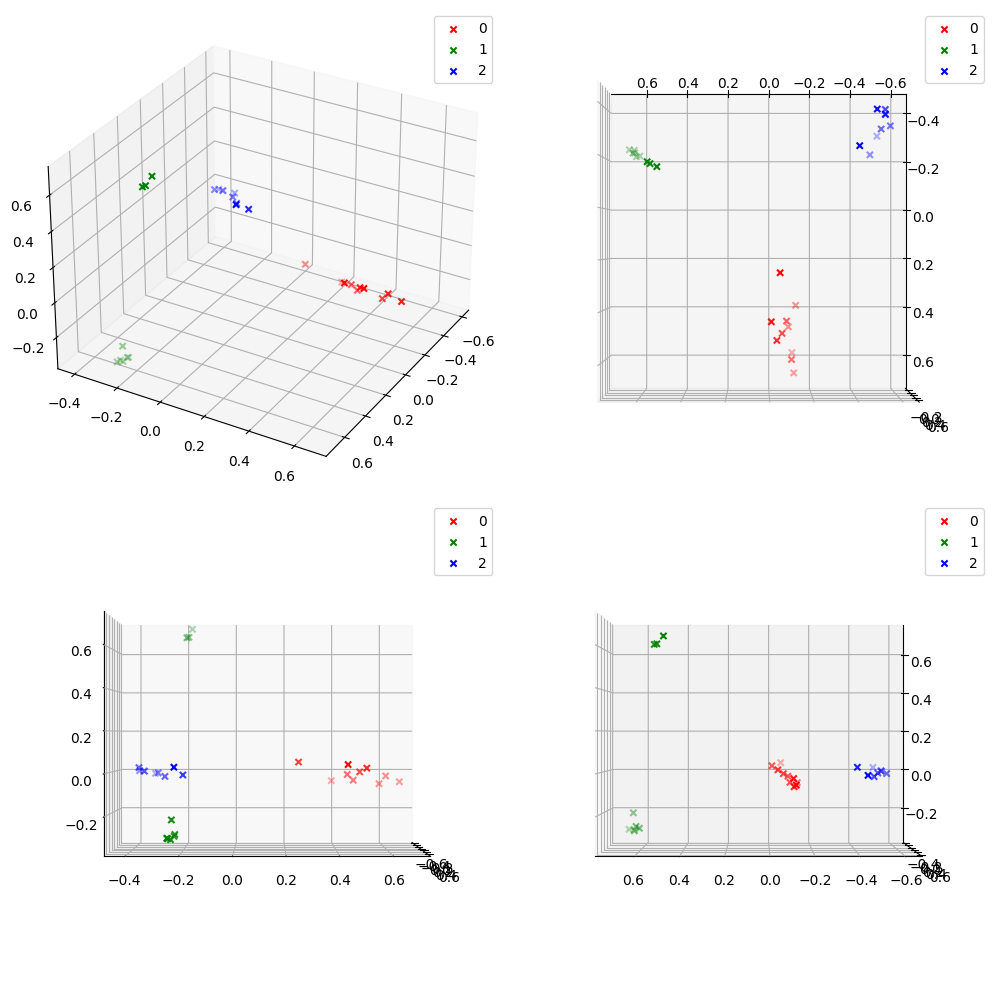

In [204]:
fig = plt.figure(figsize=(10,10))

for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x', label=label)
        ax.view_init(elev=o[0], azim=o[1])
    ax.legend()

plt.tight_layout()
plt.show()

In [47]:
from sklearn.cluster import OPTICS, DBSCAN
clustering = DBSCAN(eps=0.4, min_samples=5)
labels = clustering.fit_predict(features_PCA)
labels

array([-1,  0,  1,  2,  0,  1,  1,  2,  2,  0,  2,  2,  2,  0,  2,  0,  2,
        1,  0,  1,  1,  0,  1,  1,  1,  0,  0,  2])

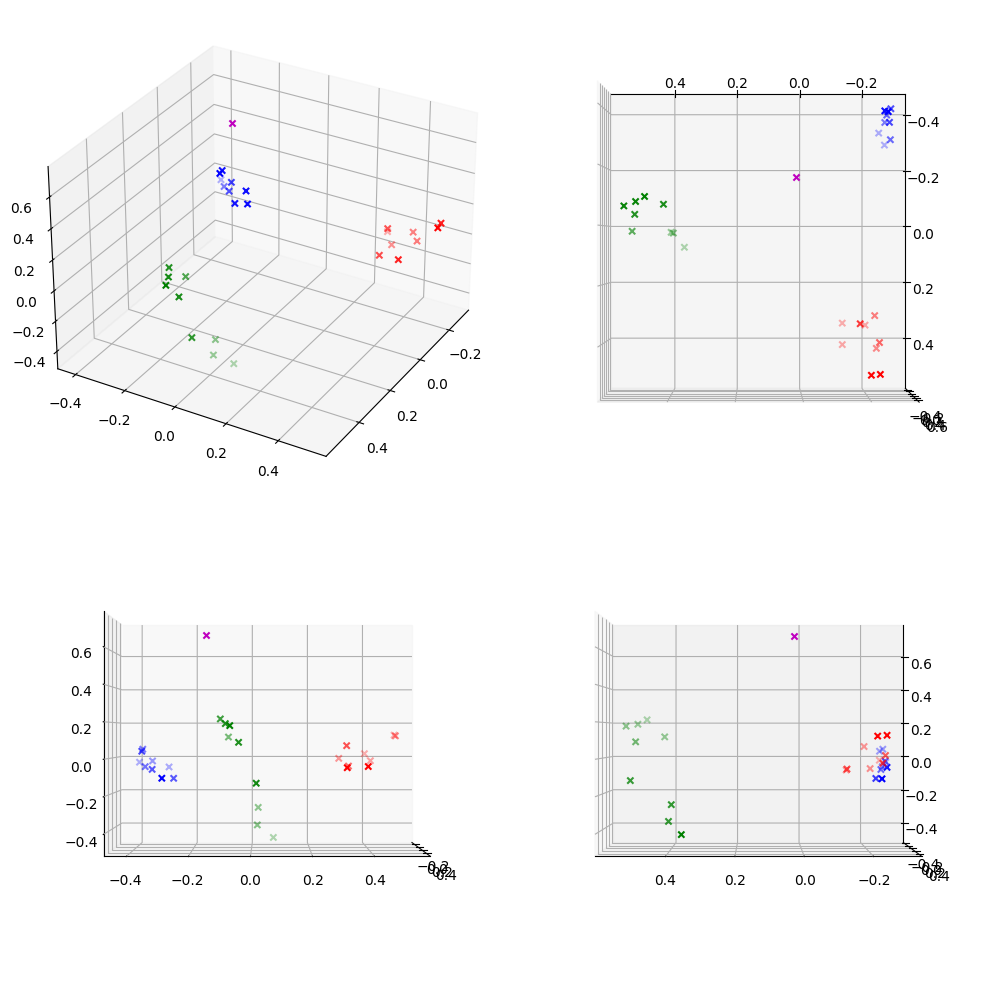

In [48]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])
plt.tight_layout()
plt.show()

In [98]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=10)
labels = kmeans.fit_predict(features_PCA)
labels

array([0, 0, 3, 2, 2, 1, 1, 1, 0, 2, 3, 1, 0, 1, 0, 3, 3, 0, 0, 1, 0, 2,
       0, 2, 1, 1, 1, 1], dtype=int32)

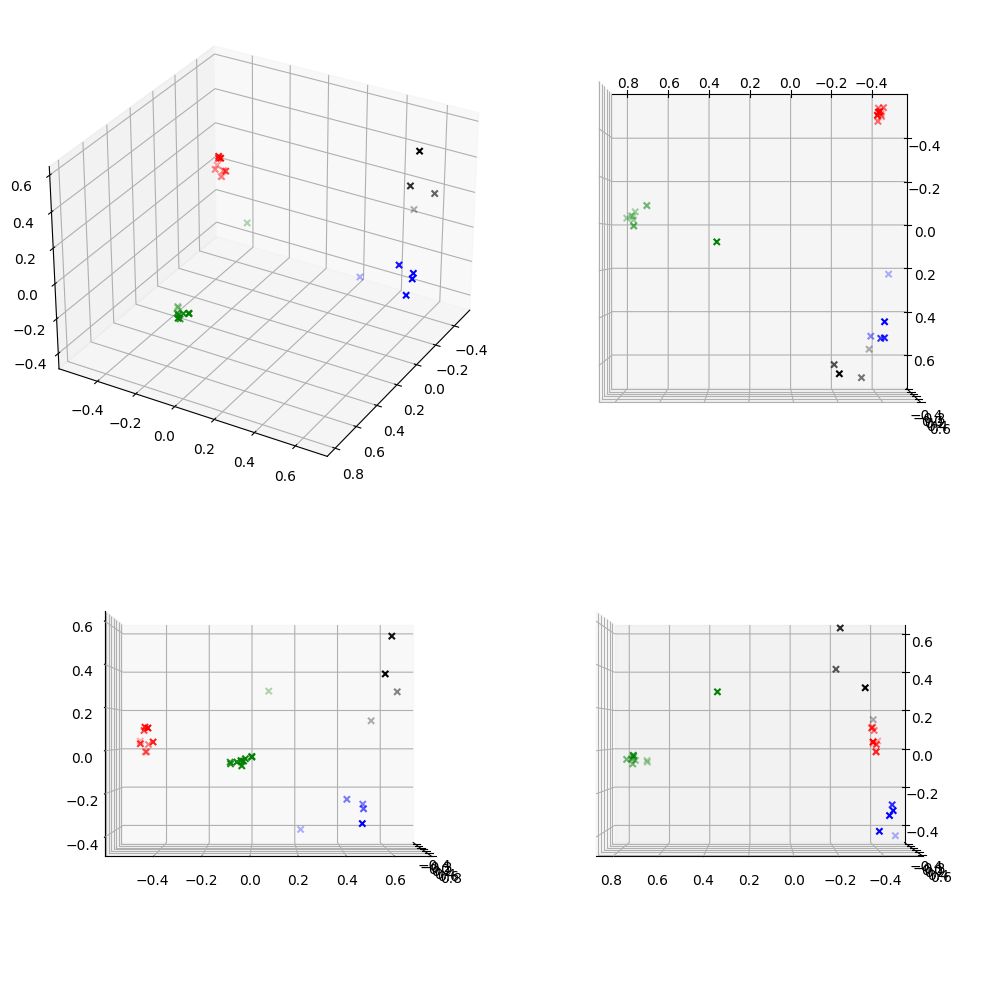

In [99]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()